## RLlib for multi-agent RL

In [2]:
# HIDDEN
import gym
import numpy as np
import matplotlib.pyplot as plt
plt.rcParams['font.size'] = 16
# https://github.com/sven1977/rllib_tutorials/blob/main/ray_summit_2021/tutorial_notebook.ipynb
# https://github.com/anyscale/ray-summit-2022-training/blob/main/ray-rllib/ex_02_create_multiagent_rllib_env.ipynb

import warnings
warnings.filterwarnings("ignore", category=DeprecationWarning) 

#### Test

Test

#### Multi agent arena

![](img/multi-agent-arena.png)

Notes:

We have two agents, agent 1 and agent 2. In this case they have the same actions spaces and observations spaces but (critically) different reward functions. Agent 1 gets positive rewards if it explores a new square field, and a negative reward if it collides with agent 2. Agent 2 gets positive reward if it collides with agent 2. So in a way this is a game of tag, with agent 2 trying to catch agent 1, but agent 1 also has the additional goal of trying to explore territory rather than purely just running away. Since the field is 8x8, there are 64 squares. Our observation space is MultiDiscrete(64,64) because it contains the location of agent 1 (discrete 64) and agent 2 (also discrete 64).

#### Some code

In [3]:
from envs import MultiAgentArena

In [24]:
env = MultiAgentArena(config={"render": True})
env.reset()

Output()

{'agent1': array([ 0, 99]), 'agent2': array([99,  0])}

NOTE HOW BOTH AGENTS SEE THE SAME THING in this case - both agents see both locations

In [25]:
env.render()

____________
|1         |
|          |
|          |
|          |
|          |
|          |
|          |
|          |
|          |
|         2|
‾‾‾‾‾‾‾‾‾‾‾‾

R1= 0.0
R2= 0.0 (0 collisions)



In [19]:
obs, reward, dones, _ = env.step({"agent1": 2, "agent2": 0})

In [20]:
obs

{'agent1': array([20, 79]), 'agent2': array([79, 20])}

In [21]:
reward

{'agent1': 1.0, 'agent2': -0.1}

In [22]:
dones

{'agent1': False, 'agent2': False, '__all__': False}

The `"__all__"` is True when both (all) agents are done.

In [26]:
env.render()

____________
|1         |
|          |
|          |
|          |
|          |
|          |
|          |
|          |
|          |
|         2|
‾‾‾‾‾‾‾‾‾‾‾‾

R1= 0.0
R2= 0.0 (0 collisions)



Note how agent 1 collected reward of +1 for exploring whereas agent 2 collected -0.1 for a regular move.

The env code can be viewed on the github

____________
|.         |
|...       |
|  1       |
|          |
|          |
|          |
|          |
|       2  |
|          |
|          |
‾‾‾‾‾‾‾‾‾‾‾‾

R1= 4.0
R2=-0.4 (0 collisions)

Agent1's x/y position=[2, 2]
Agent2's x/y position=[7, 7]
Env timesteps=4


In [5]:
from ray.rllib.algorithms.ppo import PPOConfig

ppo_config = (
    PPOConfig()\
    .framework("torch")\
    .rollouts(create_env_on_local_worker=True)\
    .debugging(seed=0, log_level="ERROR")\
    .training(model={"fcnet_hiddens" : [64, 64]})\
    .multi_agent(
        policies=["policy1", "policy2"],
        policy_mapping_fn=lambda agent_id, episode, worker, **kwargs: "policy1" if agent_id == "agent1" else "policy2"
    )
)

#### Multi-policy

![](img/from_single_agent_to_multi_agent.png)

In [6]:
ppo = ppo_config.build(env=MultiAgentArena)

(RolloutWorker pid=42804) /Users/mike/git/anyscale/ray/python/ray/rllib/utils/debug/deterministic.py:42: DeprecationWarning: distutils Version classes are deprecated. Use packaging.version instead.
(RolloutWorker pid=42804)   if LooseVersion(torch.__version__) >= LooseVersion("1.8.0"):
(RolloutWorker pid=42804) /Users/mike/miniconda3/envs/ray2beta/lib/python3.9/site-packages/gym/core.py:268: DeprecationWarning: WARN: Function `env.seed(seed)` is marked as deprecated and will be removed in the future. Please use `env.reset(seed=seed)` instead.
(RolloutWorker pid=42804)   deprecation(
(RolloutWorker pid=42805) /Users/mike/git/anyscale/ray/python/ray/rllib/utils/debug/deterministic.py:42: DeprecationWarning: distutils Version classes are deprecated. Use packaging.version instead.
(RolloutWorker pid=42805)   if LooseVersion(torch.__version__) >= LooseVersion("1.8.0"):
(RolloutWorker pid=42805) /Users/mike/miniconda3/envs/ray2beta/lib/python3.9/site-packages/gym/core.py:268: DeprecationWarn

In [7]:
rewards1 = []
rewards2 = []
for i in range(20):
    result = ppo.train()
    rewards1.append(result['policy_reward_mean']['policy1'])
    rewards2.append(result['policy_reward_mean']['policy2'])

In [8]:
# HIDDEN
rewards1 = np.array(rewards1)
rewards2 = np.array(rewards2)

#### Training curve

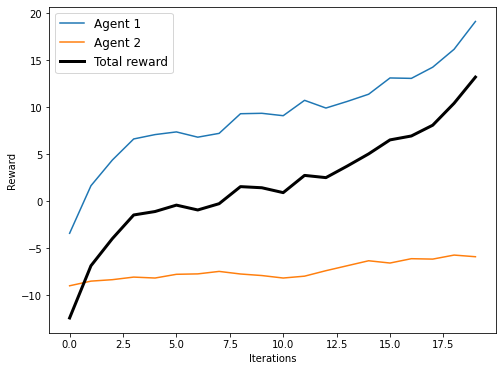

In [9]:
plt.figure(figsize=(8,6));
plt.plot(rewards1, label="Agent 1")
plt.plot(rewards2, label="Agent 2")
plt.plot(rewards1+rewards2, label="Total reward", linewidth=3, color="black")
plt.legend(fontsize=12);
plt.xlabel("Iterations")
plt.ylabel("Reward");

Notes:

Note that in an adversarial multi-agent setup, an agent benefits from the other agent's failures and vice-versa: agents receive negative rewards the better the other agent is doing. This highlights some important aspects of multi-agent training:

- From each agent's perspective, the environment is not as static as in respective single-agent scenarios (the other agent's behavior is probably harder to predict than the environment's own inherent dynamics/physics).
- As one agent learns how to behave more intelligently, the other agent has to counter this new behavior of its opponent and become smarter as well. 

#### Actions

In [34]:
obs

{'agent1': array([ 0, 99]), 'agent2': array([99,  0])}

In [ ]:
obs

In [51]:
obs = env.reset()

ppo.compute_single_action(obs["agent1"], policy_id="policy1")

ppo.compute_single_action(obs["agent2"], policy_id="policy2")

0

We need to pass in the observation for that agent, and also the correct policy since we are using separate policies.

#### Let's apply what we learned!

## Multi-agent RL use cases
<!-- multiple choice -->

Which of the following is **NOT** a reasonable use case of multi-agent RL?

- [ ] Multiple competing agents learning to play an adversarial game.
- [ ] Multiple cooperative agents learning to play a cooperative game.
- [ ] Learning to operate in a financial market with multiple stakeholders.
- [x] Frozen Lake

## What do the agents share?
<!-- multiple choice -->

#### Observations and actions: our example

Which of the following is true **about our arena example specifically**?

- [ ] The agents share the same observation space but have different action spaces.
- [ ] The agents share the same action space but have different observation spaces.
- [x] The agents share the same observation and action spaces.
- [ ] The agents have different observation and action spaces.

#### Observations and actions: in general

Which of the following is true **about multi-agent RL in general**?

- [ ] The agents always share the same observation space but may have different action spaces.
- [ ] The agents always share the same action space but may have different observation spaces.
- [ ] The agents always share the same observation and action spaces.
- [x] The agents may have different observation and action spaces.

#### Rewards and policies: our example

Which of the following is true **about our arena example specifically**?

- [ ] The agents have the same goals but different policies.
- [ ] The agents have the same policies but different goals.
- [ ] The agents have the same goals and the same policies. 
- [x] The agents have different goals and different policies.

## Visualizing the trained arena agent
<!-- coding exercise -->

In the slides we trained two agents to play the arena game. In the code below, we restore the agent that was trained in the slides. Fill in the missing code so that we can watch the trained agents play the game. Then, answer the multiple choice question below.

In [10]:
# EXERCISE

In [14]:
# SOLUTION
from envs import MultiAgentArena
from ray.rllib.algorithms.ppo import PPOConfig

ppo_config = (
    PPOConfig()\
    .framework("torch")\
    .rollouts(create_env_on_local_worker=True)\
    .debugging(seed=0, log_level="ERROR")\
    .training(model={"fcnet_hiddens" : [64, 64]})\
    .multi_agent(
        policies=["policy1", "policy2"],
        policy_mapping_fn=lambda agent_id, episode, worker, **kwargs: "policy1" if agent_id == "agent1" else "policy2"
    )
)

ppo = ppo_config.build(env=MultiAgentArena)

ppo.restore("models/MultiAgent/checkpoint-20")

env = MultiAgentArena(config={"render": True})
env.reset()
dones = {"__all__" : False}
with env.out:
    
    while not dones["__all__"]:

        action1 = ppo.compute_single_action(obs["agent1"], policy_id="policy1")
        action2 = ppo.compute_single_action(obs["agent2"], policy_id="policy2")
        
        obs, rewards, dones, infos = env.step({"agent1": action1, "agent2": action2})
        env.render()


print("Agent1's x/y position={}".format(env.agent1_pos))
print("Agent2's x/y position={}".format(env.agent2_pos))
print("Env timesteps={}".format(env.timesteps))

(RolloutWorker pid=43284) /Users/mike/git/anyscale/ray/python/ray/rllib/utils/debug/deterministic.py:42: DeprecationWarning: distutils Version classes are deprecated. Use packaging.version instead.
(RolloutWorker pid=43284)   if LooseVersion(torch.__version__) >= LooseVersion("1.8.0"):
(RolloutWorker pid=43284) /Users/mike/miniconda3/envs/ray2beta/lib/python3.9/site-packages/gym/core.py:268: DeprecationWarning: WARN: Function `env.seed(seed)` is marked as deprecated and will be removed in the future. Please use `env.reset(seed=seed)` instead.
(RolloutWorker pid=43284)   deprecation(
(RolloutWorker pid=43283) /Users/mike/git/anyscale/ray/python/ray/rllib/utils/debug/deterministic.py:42: DeprecationWarning: distutils Version classes are deprecated. Use packaging.version instead.
(RolloutWorker pid=43283)   if LooseVersion(torch.__version__) >= LooseVersion("1.8.0"):
(RolloutWorker pid=43283) /Users/mike/miniconda3/envs/ray2beta/lib/python3.9/site-packages/gym/core.py:268: DeprecationWarn

TypeError: can't convert np.ndarray of type numpy.object_. The only supported types are: float64, float32, float16, complex64, complex128, int64, int32, int16, int8, uint8, and bool.

#### Choose the option below that best describes the agents' behavior.

- [x] 
- [ ] 
- [ ] 
- [ ] 